[View in Colaboratory](https://colab.research.google.com/github/exitsky/sky/blob/master/fashion_mnist_train_LeNet0.ipynb)

In [0]:
import numpy as np


def smooth_curve(x):
    window_len = 11
    s = np.r_[x[window_len - 1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w / w.sum(), s, mode='valid')
    return y[5:len(y) - 5]


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    npad = [(0, 0), (0, 0), (pad, pad), (pad, pad)]
    img = np.pad(input_data, npad, 'constant')

    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]
  
  
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x >= 0] = 1
    return grad


def softmax(x):
    if x.ndim == 2: 
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t) ** 2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(x, t):
    y = softmax(x)
    return cross_entropy_error(y, t)

  
  
  
  
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        self.original_x_shape = None

    def forward(self, x):
        self.original_x_shape = x.shape

        if x.ndim == 1:
            x = x.reshape(1, x.size)
            
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

    
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var

        self.batch_size = None
        self.xc = None
        self.xn = None
        self.std = None

        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flag=True):
        self.input_shape = x.shape

        if x.ndim != 2:
            N, C, H, W = x.shape
#             print("BatchNormalization forward -> N: {}, C: {}, H: {}, W: {}".format(N, C, H, W))
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flag)
        return out.reshape(*self.input_shape)

    def __forward(self, x, train_flag):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        if train_flag:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc ** 2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var

        else:
            xc = x - self.running_mean
            xn = xc / (np.sqrt(self.running_var + 10e-7))

        out = self.gamma * xn + self.beta
        return out


    def backward(self, dout):
        if dout.ndim != 2 :
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis = 0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar

        dmu = -np.sum(dxc, axis=0)
        dx = dxc + dmu / self.batch_size

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx


class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None
        self.col = None
        self.col_W = None

        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape

        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)


        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx
  
  
  
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        print(self.lr, self.momentum)

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / ((np.sqrt(self.h[key])) + 1e-8)


class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            # 분산 mean square
            # h <- ah + (1 - a) * (dw * dw)
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            # 표준편차 root mean square : 1/sqrt(h)
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-8)


class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 0
        self.m = None
        self.v = None


    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.t += 1
        alpha = self.lr * np.sqrt(1.0 - self.beta2 ** self.t) / (1.0 - self.beta1 ** self.t)

        for key in params.keys() :
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

            params[key] -= alpha * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [0]:
import numpy as np

class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test
                 , epochs=20
                 , mini_batch_size=100
                 , optimizer='sgd'
                 , optimizer_param={'lr': 0.01}
                 , evaluate_sample_num_per_epoch=None
                 , verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        optimizer_class_dict = {'sgd': SGD, 'momentum': Momentum, 'nesterov': Nesterov, 'adagrad': AdaGrad, 'rmsprpo': RMSprop, 'adam': Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
#         if self.verbose: print("train loss:" + str(loss))

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]

            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print(
                "=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")

        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [0]:
import pickle
from collections import OrderedDict


class LeNet:
    """
    네트워크 구성은 아래와 같음
        conv - relu - pool-
        conv - relu - pool -
        affine - relu - 
        affine - softmax
    """

    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num': 6, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 conv_param_2={'filter_num': 16, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size_list=[100],
                 output_size=10,
                 weight_init_std=0.01):
        self.conv_layer_num = len([conv_param_1, conv_param_2])
        self.affine_layer_size_list = hidden_size_list + [output_size]
        self.conv_affine_layer_num = self.conv_layer_num + len(self.affine_layer_size_list)
     
        self.params = {}
        pre_channel_num = input_dim[0]

        # < 가중치 초기화 >    
        for idx, conv_param in enumerate([conv_param_1, conv_param_2]):
            self.params['W' + str(idx + 1)] = weight_init_std * np.random.randn(conv_param['filter_num'],
                                                                                       pre_channel_num,
                                                                                       conv_param['filter_size'],
                                                                                       conv_param['filter_size'])
            self.params['b' + str(idx + 1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']

        self.params['W3'] = weight_init_std * np.random.randn(16 * 4 * 4, hidden_size_list[0])
        self.params['b3'] = np.zeros(hidden_size_list[0])
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size_list[0], output_size)
        self.params['b4'] = np.zeros(output_size)

    
        # < 계층 생성 >
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = Relu()
        self.layers['Pool2'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])
        self.last_layer = SoftmaxWithLoss()
        

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            x = layer.forward(x)

        return x


    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)


    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return (acc / x.shape[0]) * 100     # 백분률 (%)

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 기울기 계산 결과
        grads = {}
        for idx in range(1, self.conv_layer_num + 1):
            grads['W' + str(idx)] = self.layers['Conv' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Conv' + str(idx)].db

        for idx in range(self.conv_layer_num + 1, self.conv_affine_layer_num + 1):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


=== epoch:1, train acc:21.3, test acc:21.9 ===
=== epoch:2, train acc:84.6, test acc:85.0 ===
=== epoch:3, train acc:89.1, test acc:86.2 ===
=== epoch:4, train acc:90.6, test acc:87.9 ===
=== epoch:5, train acc:91.3, test acc:88.6 ===
=== epoch:6, train acc:90.2, test acc:87.0 ===
=== epoch:7, train acc:92.1, test acc:88.2 ===
=== epoch:8, train acc:92.5, test acc:87.4 ===
=== epoch:9, train acc:92.2, test acc:89.0 ===
=== epoch:10, train acc:91.5, test acc:88.2 ===
=== epoch:11, train acc:93.2, test acc:89.2 ===
=== epoch:12, train acc:93.1, test acc:88.4 ===
=== epoch:13, train acc:94.1, test acc:89.6 ===
=== epoch:14, train acc:93.5, test acc:89.6 ===
=== epoch:15, train acc:93.9, test acc:88.6 ===
=============== Final Test Accuracy ===============
test acc:89.05


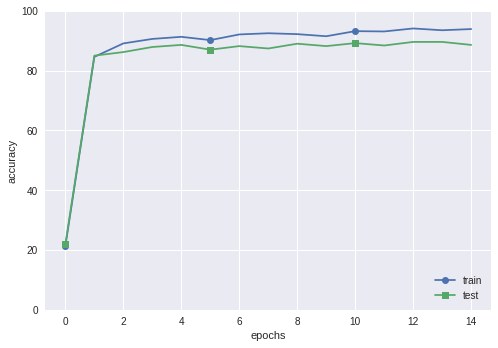

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


##############################################################################
# Download the fashion_mnist data
##############################################################################
(x_train, t_train), (x_test, t_test) = tf.keras.datasets.fashion_mnist.load_data()


###################################################################
# Fashion Mnist 데이터가 기존 Mnist와 데이터 포맷이 달라서 코드가 호환이 안된다.
# 아래 코드를 사용해서 변환하면된다
###################################################################
x_train=np.expand_dims(x_train,axis=1)
x_test=np.expand_dims(x_test,axis=1)


# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:10000], t_train[:10000]
# x_test, t_test = x_test[:1000], t_test[:1000]

network = LeNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test
                  , epochs=15
                  , mini_batch_size=100 
                  , optimizer='Adam'
                  , optimizer_param={'lr':0.001}
                  , evaluate_sample_num_per_epoch=1000)

trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=5)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=5)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 100.0)
plt.legend(loc='lower right')
plt.show()
